In [31]:
import geopandas as gpd
import rasterio
from shapely.geometry import box, Point
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from itertools import starmap
import requests
import zipfile
import io
import boto3
from tqdm import tqdm
from rasterio.crs import CRS

from dem_stitcher.geojson_io import to_geojson_gzip
from dem_stitcher.dem_readers import read_srtm, read_nasadem

In [32]:
DATA_PATH = Path('data')
DATA_PATH.mkdir(exist_ok=True)

# SRTM

From here: https://figshare.com/articles/dataset/Vector_grid_of_SRTM_1x1_degree_tiles/1332753

In [3]:
df_srtm_raw = gpd.read_file('https://ndownloader.figshare.com/files/1944795')
df_srtm_raw.head()

,id,geometry
0,N00E006,"POLYGON ((6.00000 0.00000, 6.00000 1.00000, 7...."
1,N00E009,"POLYGON ((9.00000 0.00000, 9.00000 1.00000, 10..."
2,N00E010,"POLYGON ((10.00000 0.00000, 10.00000 1.00000, ..."
3,N00E011,"POLYGON ((11.00000 0.00000, 11.00000 1.00000, ..."
4,N00E012,"POLYGON ((12.00000 0.00000, 12.00000 1.00000, ..."


In [4]:
df_srtm = df_srtm_raw.copy()
df_srtm.rename(columns={'id': 'tile_id'}, inplace=True)
df_srtm['url'] = df_srtm['tile_id'].map(lambda tile_id: f'http://e4ftl01.cr.usgs.gov/MEASURES/SRTMGL1.003/2000.02.11/{tile_id}.SRTMGL1.hgt.zip')
df_srtm = df_srtm[['tile_id', 'url', 'geometry']].copy()
df_srtm.url = df_srtm.url.map(lambda url: url.replace('http://', 'https://'))
df_srtm.head()

,tile_id,url,geometry
0,N00E006,https://e4ftl01.cr.usgs.gov/MEASURES/SRTMGL1.0...,"POLYGON ((6.00000 0.00000, 6.00000 1.00000, 7...."
1,N00E009,https://e4ftl01.cr.usgs.gov/MEASURES/SRTMGL1.0...,"POLYGON ((9.00000 0.00000, 9.00000 1.00000, 10..."
2,N00E010,https://e4ftl01.cr.usgs.gov/MEASURES/SRTMGL1.0...,"POLYGON ((10.00000 0.00000, 10.00000 1.00000, ..."
3,N00E011,https://e4ftl01.cr.usgs.gov/MEASURES/SRTMGL1.0...,"POLYGON ((11.00000 0.00000, 11.00000 1.00000, ..."
4,N00E012,https://e4ftl01.cr.usgs.gov/MEASURES/SRTMGL1.0...,"POLYGON ((12.00000 0.00000, 12.00000 1.00000, ..."


In [5]:
to_geojson_gzip(df_srtm, DATA_PATH/'srtm_v3.geojson.zip')

PosixPath('data/srtm_v3.geojson.zip')

In [6]:
urls = df_srtm.url.to_list()

X, p = read_srtm(urls[0])

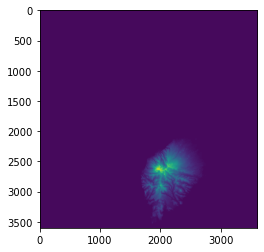

In [7]:
plt.imshow(X)

# NASADEM

In [8]:
df_nasadem = df_srtm.copy()
URL = 'https://e4ftl01.cr.usgs.gov/MEASURES/NASADEM_HGT.001/2000.02.11'
df_nasadem['url'] = df_nasadem.tile_id.map(lambda tile_id: f'{URL}/NASADEM_HGT_{tile_id.lower()}.zip')
df_nasadem.head()

,tile_id,url,geometry
0,N00E006,https://e4ftl01.cr.usgs.gov/MEASURES/NASADEM_H...,"POLYGON ((6.00000 0.00000, 6.00000 1.00000, 7...."
1,N00E009,https://e4ftl01.cr.usgs.gov/MEASURES/NASADEM_H...,"POLYGON ((9.00000 0.00000, 9.00000 1.00000, 10..."
2,N00E010,https://e4ftl01.cr.usgs.gov/MEASURES/NASADEM_H...,"POLYGON ((10.00000 0.00000, 10.00000 1.00000, ..."
3,N00E011,https://e4ftl01.cr.usgs.gov/MEASURES/NASADEM_H...,"POLYGON ((11.00000 0.00000, 11.00000 1.00000, ..."
4,N00E012,https://e4ftl01.cr.usgs.gov/MEASURES/NASADEM_H...,"POLYGON ((12.00000 0.00000, 12.00000 1.00000, ..."


In [9]:
urls = df_nasadem.url.to_list()

X, p = read_nasadem(urls[0])

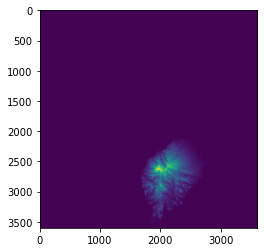

In [10]:
plt.imshow(X)

In [11]:
to_geojson_gzip(df_nasadem, DATA_PATH/'nasadem.geojson.zip')

PosixPath('data/nasadem.geojson.zip')

# GLO

In the past, there was a shapefile that could be accessed, but that is now gone. We go through the buckets.

In [4]:
## Can update when new year is available
# YEAR = '2021'
## Currently Only 1 year is available

# Change resolution to 30 or 90
RES = 90

assert(RES in [30, 90])

In [5]:
s3client = boto3.client('s3')
BUCKET_NAME = f'copernicus-dem-{RES}m'
objects = s3client.list_objects(Bucket=BUCKET_NAME)
objects['Contents'][:5]

[{'Key': 'Copernicus_DSM_COG_30_N00_00_E006_00_DEM/AUXFILES/Copernicus_DSM_30_N00_00_E006_00_ACM.kml',
  'LastModified': datetime.datetime(2022, 5, 9, 12, 43, 24, tzinfo=tzutc()),
  'ETag': '"8fad074b0c6d0c80716f694674b90a1e"',
  'Size': 732,
  'StorageClass': 'STANDARD'},
 {'Key': 'Copernicus_DSM_COG_30_N00_00_E006_00_DEM/AUXFILES/Copernicus_DSM_COG_30_N00_00_E006_00_EDM.tif',
  'LastModified': datetime.datetime(2022, 5, 9, 12, 43, 24, tzinfo=tzutc()),
  'ETag': '"6b9d5ae5591a9ad5b5da334bbe9cf45e"',
  'Size': 50244,
  'StorageClass': 'STANDARD'},
 {'Key': 'Copernicus_DSM_COG_30_N00_00_E006_00_DEM/AUXFILES/Copernicus_DSM_COG_30_N00_00_E006_00_FLM.tif',
  'LastModified': datetime.datetime(2022, 5, 9, 12, 43, 24, tzinfo=tzutc()),
  'ETag': '"d34a617f3c36dde49e998546e2ad423d"',
  'Size': 53031,
  'StorageClass': 'STANDARD'},
 {'Key': 'Copernicus_DSM_COG_30_N00_00_E006_00_DEM/AUXFILES/Copernicus_DSM_COG_30_N00_00_E006_00_HEM.tif',
  'LastModified': datetime.datetime(2022, 5, 9, 12, 43, 24,

In [7]:
paginator = s3client.get_paginator('list_objects_v2')
pages = paginator.paginate(Bucket=BUCKET_NAME)

In [8]:
all_contents = []
for page in tqdm(pages):
    all_contents.extend(page['Contents'])

all_contents[0]

424it [02:50,  2.48it/s]


{'Key': 'Copernicus_DSM_COG_30_N00_00_E006_00_DEM/AUXFILES/Copernicus_DSM_30_N00_00_E006_00_ACM.kml',
 'LastModified': datetime.datetime(2022, 5, 9, 12, 43, 24, tzinfo=tzutc()),
 'ETag': '"8fad074b0c6d0c80716f694674b90a1e"',
 'Size': 732,
 'StorageClass': 'STANDARD'}

In [9]:
tif_obs = list(filter(lambda ob: '.tif' in ob['Key'], all_contents))
tif_obs = list(filter(lambda ob: ('AUXFILES' not in ob['Key']) and ('PREVIEW' not in ob['Key']), tif_obs))
tif_obs[:3]

[{'Key': 'Copernicus_DSM_COG_30_N00_00_E006_00_DEM/Copernicus_DSM_COG_30_N00_00_E006_00_DEM.tif',
  'LastModified': datetime.datetime(2022, 5, 9, 12, 43, 24, tzinfo=tzutc()),
  'ETag': '"0c3f5310131359cfa2dfb028bf3510fd"',
  'Size': 490119,
  'StorageClass': 'STANDARD'},
 {'Key': 'Copernicus_DSM_COG_30_N00_00_E009_00_DEM/Copernicus_DSM_COG_30_N00_00_E009_00_DEM.tif',
  'LastModified': datetime.datetime(2022, 5, 9, 12, 43, 24, tzinfo=tzutc()),
  'ETag': '"4a63321e22c176df173951a67c79580a"',
  'Size': 3210718,
  'StorageClass': 'STANDARD'},
 {'Key': 'Copernicus_DSM_COG_30_N00_00_E010_00_DEM/Copernicus_DSM_COG_30_N00_00_E010_00_DEM.tif',
  'LastModified': datetime.datetime(2022, 5, 9, 12, 43, 24, tzinfo=tzutc()),
  'ETag': '"c577e54674b6ae8abd4b246a25a52936"',
  'Size': 5763057,
  'StorageClass': 'STANDARD'}]

In [10]:
len(tif_obs)

26475

In [11]:
def get_bbox_glo(tile_id):
    tokens = tile_id.split('_')
    lat_sign = tokens[4]
    lon_sign = tokens[6]
    
    if lat_sign[0] == 'N':
        lat = int(lat_sign[1:])
    elif lat_sign[0] == 'S':
        lat = -int(lat_sign[1:])
    else:
        raise ValueError('Latitude token not expected')
    
    if lon_sign[0] == 'W':
        lon = -int(lon_sign[1:])
    elif lon_sign[0] == 'E':
        lon = int(lon_sign[1:])
    else:
        raise ValueError('Longitude token not expected')
    return box(lon, lat, lon + 1, lat+1)

def format_glo(data):
    out_data = {}
    key = data['Key']
    tile_id = key.split('/')[-1].replace('.tif', '')
    out_data['tile_id'] = tile_id
    out_data['url'] = f'https://copernicus-dem-{RES}m.s3.amazonaws.com/{key}'
    out_data['last_modified'] = data['LastModified']
    out_data['geometry'] = get_bbox_glo(tile_id)
    return out_data

In [12]:
tile_data = list(map(format_glo, tif_obs))

df_glo = pd.DataFrame(tile_data)
df_glo = df_glo.sort_values(by=['tile_id', 'last_modified'], ascending=True)
df_glo.drop_duplicates(subset='tile_id', keep='last', inplace=True)
df_glo = gpd.GeoDataFrame(df_glo, geometry=df_glo.geometry, crs=CRS.from_epsg(4326))
df_glo = df_glo[['tile_id', 'url', 'geometry']].copy()
df_glo.head()

,tile_id,url,geometry
0,Copernicus_DSM_COG_30_N00_00_E006_00_DEM,https://copernicus-dem-90m.s3.amazonaws.com/Co...,"POLYGON ((7.00000 0.00000, 7.00000 1.00000, 6...."
1,Copernicus_DSM_COG_30_N00_00_E009_00_DEM,https://copernicus-dem-90m.s3.amazonaws.com/Co...,"POLYGON ((10.00000 0.00000, 10.00000 1.00000, ..."
2,Copernicus_DSM_COG_30_N00_00_E010_00_DEM,https://copernicus-dem-90m.s3.amazonaws.com/Co...,"POLYGON ((11.00000 0.00000, 11.00000 1.00000, ..."
3,Copernicus_DSM_COG_30_N00_00_E011_00_DEM,https://copernicus-dem-90m.s3.amazonaws.com/Co...,"POLYGON ((12.00000 0.00000, 12.00000 1.00000, ..."
4,Copernicus_DSM_COG_30_N00_00_E012_00_DEM,https://copernicus-dem-90m.s3.amazonaws.com/Co...,"POLYGON ((13.00000 0.00000, 13.00000 1.00000, ..."


In [13]:
to_geojson_gzip(df_glo, DATA_PATH/f'glo_{RES}.geojson.zip')

PosixPath('data/glo_90.geojson.zip')

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 1200, 'height': 1200, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0008333333333333334, 0.0, 17.999583333333334,
       0.0, -0.0008333333333333334, 1.0004166666666667), 'blockxsize': 2048, 'blockysize': 2048, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}

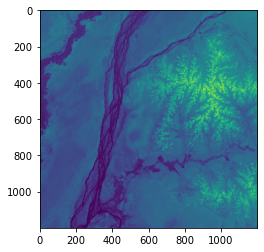

In [14]:
urls = df_glo.url.tolist()
k = 10

with rasterio.open(urls[k]) as ds:
    X = ds.read(1)
    p = ds.profile
plt.imshow(X)
p

# 3dep

## Read through S3 Bucket

In [33]:
RESOLUTION = 13 # 1/3 arc second

In [38]:
s3client = boto3.client('s3')
BUCKET_NAME = 'prd-tnm'
objects = s3client.list_objects(Bucket=BUCKET_NAME,
                                Prefix=f'StagedProducts/Elevation/{RESOLUTION}/TIFF/current')
objects['Contents'][:5]

[{'Key': 'StagedProducts/Elevation/13/TIFF/current/n06e162/USGS_13_n06e162.gpkg',
  'LastModified': datetime.datetime(2022, 8, 30, 16, 13, 42, tzinfo=tzutc()),
  'ETag': '"1d113fcc599fba32904e367436bd2406"',
  'Size': 98304,
  'StorageClass': 'STANDARD',
  'Owner': {'DisplayName': 'gs-chs-prod-tnm',
   'ID': '758654cd0b6595c23fd1b93aba22af0e2e19010ba4a30b77138596d8c4d308be'}},
 {'Key': 'StagedProducts/Elevation/13/TIFF/current/n06e162/USGS_13_n06e162.jpg',
  'LastModified': datetime.datetime(2022, 8, 30, 16, 13, 42, tzinfo=tzutc()),
  'ETag': '"d5bc951945efb0edf8a2ea17e6be5e20"',
  'Size': 937,
  'StorageClass': 'STANDARD',
  'Owner': {'DisplayName': 'gs-chs-prod-tnm',
   'ID': '758654cd0b6595c23fd1b93aba22af0e2e19010ba4a30b77138596d8c4d308be'}},
 {'Key': 'StagedProducts/Elevation/13/TIFF/current/n06e162/USGS_13_n06e162.tif',
  'LastModified': datetime.datetime(2022, 8, 30, 16, 13, 43, tzinfo=tzutc()),
  'ETag': '"98482c368f069c11b72d5f207e35c8a7"',
  'Size': 12500057,
  'StorageClass'

In [41]:
paginator = s3client.get_paginator('list_objects_v2')
pages = paginator.paginate(Bucket=BUCKET_NAME, 
                           Prefix=f'StagedProducts/Elevation/{RESOLUTION}/TIFF/current')

In [42]:
all_contents = []
for page in tqdm(pages):
    all_contents += page['Contents']

all_contents[0]

6it [00:01,  4.20it/s]


{'Key': 'StagedProducts/Elevation/13/TIFF/current/n06e162/USGS_13_n06e162.gpkg',
 'LastModified': datetime.datetime(2022, 8, 30, 16, 13, 42, tzinfo=tzutc()),
 'ETag': '"1d113fcc599fba32904e367436bd2406"',
 'Size': 98304,
 'StorageClass': 'STANDARD'}

In [43]:
tif_obs = list(filter(lambda ob: '.tif' in ob['Key'], all_contents))
tif_obs[:3]

[{'Key': 'StagedProducts/Elevation/13/TIFF/current/n06e162/USGS_13_n06e162.tif',
  'LastModified': datetime.datetime(2022, 8, 30, 16, 13, 43, tzinfo=tzutc()),
  'ETag': '"98482c368f069c11b72d5f207e35c8a7"',
  'Size': 12500057,
  'StorageClass': 'STANDARD'},
 {'Key': 'StagedProducts/Elevation/13/TIFF/current/n06e163/USGS_13_n06e163.tif',
  'LastModified': datetime.datetime(2022, 8, 30, 16, 13, 42, tzinfo=tzutc()),
  'ETag': '"251aa64a7ded5bea3cf10b45cac40599"',
  'Size': 10200475,
  'StorageClass': 'STANDARD'},
 {'Key': 'StagedProducts/Elevation/13/TIFF/current/n07e134/USGS_13_n07e134.tif',
  'LastModified': datetime.datetime(2022, 8, 30, 16, 13, 43, tzinfo=tzutc()),
  'ETag': '"2ccb343a6545f9da79aecf7b40857319"',
  'Size': 9205170,
  'StorageClass': 'STANDARD'}]

In [44]:
def get_bbox(tile_id):
    lat_sign = tile_id[0]
    lat_num = int(tile_id[1:3])
    lon_sign = tile_id[3]
    lon_num = int(tile_id[4:7])
    
    assert((lat_sign in ['n', 's']) and (lon_sign in ['e', 'w']))
    lon = lon_num if lon_sign == 'e' else -lon_num
    lat = lat_num if lat_sign == 'n' else -lat_num
    
    return box(lon, lat - 1, lon + 1, lat)

def format_data(data):
    out_data = {}
    key = data['Key']
    out_data['tile_id'] = key.split('/')[-2]
    out_data['url'] = f'https://prd-tnm.s3.amazonaws.com/{key}'
    out_data['last_modified'] = data['LastModified']
    out_data['geometry'] = get_bbox(out_data['tile_id'])
    return out_data

In [45]:
tile_data = list(map(format_data, tif_obs))

df_3dep = pd.DataFrame(tile_data)
df_3dep = df_3dep.sort_values(by=['tile_id', 'last_modified'], ascending=True)
df_3dep.drop_duplicates(subset='tile_id', keep='last', inplace=True)
df_3dep = gpd.GeoDataFrame(df_3dep, geometry=df_3dep.geometry, crs=CRS.from_epsg(4326))
df_3dep = df_3dep[['tile_id', 'url', 'geometry']].reset_index(drop=True)
df_3dep.head()

,tile_id,url,geometry
0,n06e162,https://prd-tnm.s3.amazonaws.com/StagedProduct...,"POLYGON ((163.00000 5.00000, 163.00000 6.00000..."
1,n06e163,https://prd-tnm.s3.amazonaws.com/StagedProduct...,"POLYGON ((164.00000 5.00000, 164.00000 6.00000..."
2,n07e134,https://prd-tnm.s3.amazonaws.com/StagedProduct...,"POLYGON ((135.00000 6.00000, 135.00000 7.00000..."
3,n07e151,https://prd-tnm.s3.amazonaws.com/StagedProduct...,"POLYGON ((152.00000 6.00000, 152.00000 7.00000..."
4,n07e152,https://prd-tnm.s3.amazonaws.com/StagedProduct...,"POLYGON ((153.00000 6.00000, 153.00000 7.00000..."


In [49]:
with rasterio.open(df_3dep.url.tolist()[0]) as ds:
    print(ds.bounds)
    print(ds.shape)

BoundingBox(left=161.99944444444444, bottom=4.999444444440047, right=163.00055555555994, top=6.000555555555558)
(10812, 10812)


In [50]:
df_3dep.url.tolist()[:3]

['https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/13/TIFF/current/n06e162/USGS_13_n06e162.tif',
 'https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/13/TIFF/current/n06e163/USGS_13_n06e163.tif',
 'https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/13/TIFF/current/n07e134/USGS_13_n07e134.tif']

In [51]:
#df_3dep.to_file('3dep.geojson', driver='GeoJSON')
to_geojson_gzip(df_3dep, DATA_PATH/'3dep.geojson.zip')

PosixPath('data/3dep.geojson.zip')

# Ned1

Deprecated

In [39]:
# VERSION = 0

In [12]:
# s3client = boto3.client('s3')
# BUCKET_NAME = 'prd-tnm'
# objects = s3client.list_objects(Bucket=BUCKET_NAME,
#                                 Prefix=f'StagedProducts/Elevation/{VERSION}/IMG/')
# objects['Contents'][:5]

In [27]:
paginator = s3client.get_paginator('list_objects_v2')
pages_ned1 = paginator.paginate(Bucket=BUCKET_NAME, 
                                Prefix='StagedProducts/Elevation/1/IMG/')

In [13]:
# all_contents_ned1 = []
# for page in tqdm(pages_ned1):
#     all_contents_ned1 += page['Contents']

# all_contents_ned1[0]

In [14]:
# zip_ob = list(filter(lambda ob: '.zip' in ob['Key'], all_contents_ned1))
# zip_ob[:3]

In [15]:
# def get_bbox(tile_id):
#     lat_sign = tile_id[0]
#     lat_num = int(tile_id[1:3])
#     lon_sign = tile_id[3]
#     lon_num = int(tile_id[4:7])
    
#     assert((lat_sign in ['n', 's']) and (lon_sign in ['e', 'w']))
#     lon = lon_num if lon_sign == 'e' else -lon_num
#     lat = lat_num if lat_sign == 'n' else -lat_num
    
#     return box(lon, lat - 1, lon + 1, lat)

# def format_data(data):
#     out_data = {}
#     key = data['Key']
#     tile_id = key.split('/')[-1]
#     tile_id_tokens = tile_id.split('_')
#     tile_id_tokens = list(filter(lambda x: x[0] in ['n', 's'], tile_id_tokens))
#     assert(len(tile_id_tokens) == 1)
#     out_data['tile_id'] = tile_id_tokens[0].replace('.zip', '')
#     out_data['url'] = f'https://prd-tnm.s3.amazonaws.com/{key}'
#     out_data['last_modified'] = data['LastModified']
#     out_data['geometry'] = get_bbox(out_data['tile_id'])
#     return out_data

In [16]:
# tile_data_ned1 = list(map(format_data, zip_ob))

# df_ned1 = pd.DataFrame(tile_data_ned1)
# df_ned1 = df_ned1.sort_values(by=['tile_id', 'last_modified'], ascending=True)
# df_ned1.drop_duplicates(subset='tile_id', keep='last', inplace=True)
# df_ned1 = gpd.GeoDataFrame(df_ned1, geometry=df_ned1.geometry, crs=CRS.from_epsg(4326))
# df_ned1 = df_ned1[['tile_id', 'url', 'geometry']].copy()
# df_ned1.head()

In [17]:
# #df_ned1.to_file('ned1.geojson', driver='GeoJSON')
# to_geojson_gzip(df_ned1, DATA_PATH/'ned1.geojson.zip')